# Behavioral correlates of cortical semantic representations modeled by semantic word vectors

This notbook written by Satoshi Nishida includes the code underlying all figures and tables in our research paper.

## Requirements:

* FreeSurfer (https://surfer.nmr.mgh.harvard.edu/)
* ImageMagick (https://imagemagick.org/)
* The following Python libralies
 * nibabel (https://nipy.org/nibabel/)
 * mayavi (https://mayavi.readthedocs.io/)
 * pysurfer (https://pysurfer.github.io/)

In [1]:
import os
import os.path
import sys

import subprocess
import platform

import numpy as np
import pandas as pd
import h5py
from scipy import stats
from scipy.spatial import distance
import itertools

from mayavi import mlab
import nibabel as nib
from surfer import Brain

from statsmodels.stats.multitest import fdrcorrection

from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import mpl_toolkits.axes_grid1

## General settings

In [2]:
# Output directory
out_dir = "out"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

# Result data file
data_file = "data.h5"

# Vector dimensions
vecsizes = [100, 300, 500, 1000, 2000]
n_vecsizes = len(vecsizes)

# Vector dimension index for main analysis
dim_idx = 3  # Dimension = 1000

# Threshold alpha value for FDR
thresh_alpha = 0.05

## Preparation for matplotlib

In [3]:
mpl.use("Agg")
%matplotlib inline

params = {
    "figure.figsize": [6, 6],
    "figure.autolayout": False,
    "font.weight": "normal",
    "font.family": "Arial", # ~/.cache/matplotlib/fontList.json shows available fonts
    "font.size": 18,
    "legend.fontsize": 18,
    "lines.linewidth": .5,
    "axes.linewidth": .5,
    "xtick.major.width": .5,
    "ytick.major.width": .5,
    "pdf.fonttype": 42, # Avoid Type3 fonts
}
mpl.rcParams.update(params)

## Preparation for pysurfer

In [4]:
# For offscreen rendering (comment out if your envioronment needs not)
mlab.options.offscreen = True

pf = platform.system()
if pf == "Darwin":
    subjects_dir = "/Applications/freesurfer/subjects"
elif pf == "Linux":
    subjects_dir = "/usr/local/freesurfer/subjects"
    
subject_id = "fsaverage"
surf = "inflated"

lh_aparc_file = os.path.join(subjects_dir, subject_id, "label", "lh" + ".aparc.a2009s.annot")
rh_aparc_file = os.path.join(subjects_dir, subject_id, "label", "rh" + ".aparc.a2009s.annot")

# Load ROI labels and names
lh_labels, _, lh_names = nib.freesurfer.read_annot(lh_aparc_file)
rh_labels, _, rh_names = nib.freesurfer.read_annot(rh_aparc_file)

n_hemi_rois = len(lh_names)

### Function for original colormap generation

In [5]:
def generate_cmap(colors):
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v / vmax, c) )
    return LinearSegmentedColormap.from_list("custom_cmap", color_list)

## Load data

In [6]:
with h5py.File(data_file, "r") as f:
    mov1_acc = f["mov1_acc"][()]
    mov2_acc = f["mov2_acc"][()]
    mov1_fracsig = f["mov1_fracsig"][()]
    mov2_fracsig = f["mov2_fracsig"][()]
    mov1_n_voxels = f["mov1_n_voxels"][()]
    mov2_n_voxels = f["mov2_n_voxels"][()]
    
    mov1_roi_acc = f["mov1_roi_acc"][()]
    mov2_roi_acc = f["mov2_roi_acc"][()]
    mov1_roi_fracsig = f["mov1_roi_fracsig"][()]
    mov2_roi_fracsig = f["mov2_roi_fracsig"][()]
    roi_names = f["roi_names"][()]
    
    mov1_noun_dissim = f["mov1_noun_dissim"][()]
    mov2_noun_dissim = f["mov2_noun_dissim"][()]
    mov1_adj_dissim = f["mov1_adj_dissim"][()]
    mov2_adj_dissim = f["mov2_adj_dissim"][()]
    
    mov1_noun_dissim_selvox = f["mov1_noun_dissim_selvox"][()]
    mov2_noun_dissim_selvox = f["mov2_noun_dissim_selvox"][()]
    mov1_adj_dissim_selvox = f["mov1_adj_dissim_selvox"][()]
    mov2_adj_dissim_selvox = f["mov2_adj_dissim_selvox"][()]
    n_sel_voxels = f["n_sel_voxels"][()]
    
    wv_noun_dissim = f["wv_noun_dissim"][()]
    wv_adj_dissim = f["wv_adj_dissim"][()]
    
    behav_noun_dissim = f["behav_noun_dissim"][()]
    behav_adj_dissim = f["behav_adj_dissim"][()]
    nouns = f["nouns"][()]
    adjs = f["adjs"][()]
    noun_n_trials = f["noun_n_trials"][()]
    adj_n_trials = f["adj_n_trials"][()]
    
    mov1_noun_dissim_overlap = f["mov1_noun_dissim_overlap"][()]
    mov1_adj_dissim_overlap = f["mov1_adj_dissim_overlap"][()]
    behav_noun_dissim_overlap = f["behav_noun_dissim_overlap"][()]
    behav_adj_dissim_overlap = f["behav_adj_dissim_overlap"][()]

## Match the index of ROIs

In [7]:
roi_names = np.array([x.decode() for x in roi_names])
n_roi_names = len(roi_names)

roi_idx = np.zeros((2, n_hemi_rois), dtype=int) - 1  # default = -1

for i, name in enumerate(lh_names):
    mask = roi_names == "ctx_lh_" + name.decode()
    if np.any(mask):
        roi_idx[0, i] = np.where(mask)[0][0]

for i, name in enumerate(rh_names):
    mask = roi_names == "ctx_rh_" + name.decode()
    if np.any(mask):
        roi_idx[1, i] = np.where(mask)[0][0]

## Fig. 1: An example of brain model-drived word dissimilarity matrix

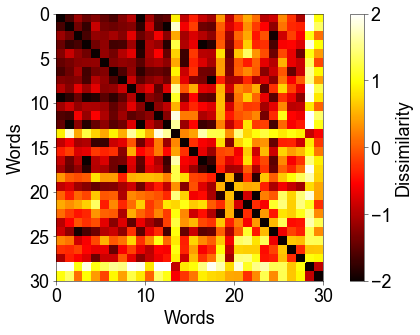

In [8]:
ex_dissim = mov1_adj_dissim[dim_idx]

n_words = 30
max_val = 2
min_val = -2

fig = plt.figure(figsize=(8, 5))

ax = plt.subplot(1, 1, 1)

mat = distance.squareform(ex_dissim)[:n_words, :n_words]
mat[np.diag_indices_from(mat)] = min_val
m = ax.pcolor(mat, cmap="hot", vmax=max_val, vmin=min_val)
ax.axis("square")

ax.set_xlabel("Words")
ax.invert_yaxis()
ax.set_ylabel("Words")

# Colorbar
cbar = fig.colorbar(m, ax=ax)
cbar.set_label("Dissimilarity")

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, 'exam_dissim_mat_brain.pdf'))
pp.savefig(fig, dpi=300, bbox_inches='tight')
pp.close()

## Fig. 2: An example of behavior-derived word dissimilarity matrix

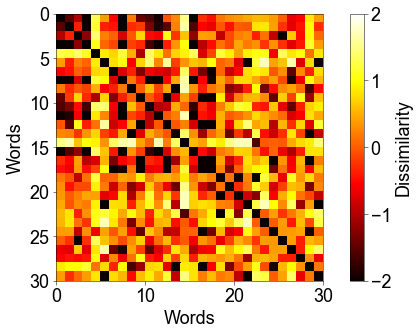

In [9]:
ex_dissim = behav_adj_dissim

n_words = 30
max_val = 2
min_val = -2

fig = plt.figure(figsize=(8, 5))

ax = plt.subplot(1, 1, 1)

mat = distance.squareform(ex_dissim)[:n_words, :n_words]
mat[np.diag_indices_from(mat)] = min_val
m = ax.pcolor(mat, cmap="hot", vmax=max_val, vmin=min_val)
ax.axis("square")

ax.set_xlabel("Words")
ax.invert_yaxis()
ax.set_ylabel("Words")

# Colorbar
cbar = fig.colorbar(m, ax=ax)
cbar.set_label("Dissimilarity")

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, 'exam_dissim_mat_behav.pdf'))
pp.savefig(fig, dpi=300, bbox_inches='tight')
pp.close()

## Figs. 3 and S1: Model accuracy

### Histogram of model accuracy

Pred acc, Movie set 1: mean = 0.09277376875813519
Frac sig, Movie set 1: mean = 0.5746972887913121
Pred acc, Movie set 2: mean = 0.08648330487310887
Frac sig, Movie set 2: mean = 0.5260665573387137


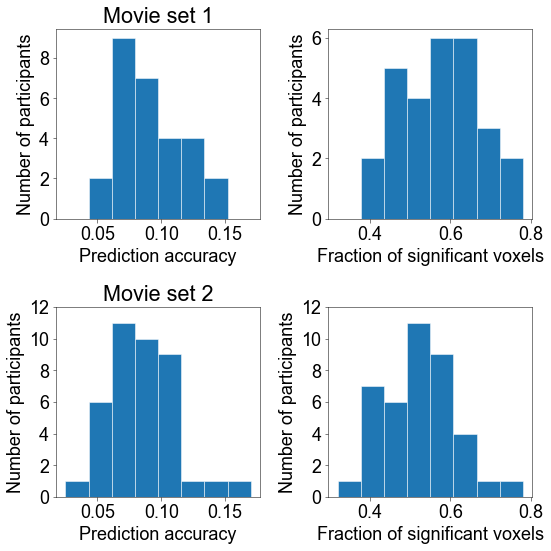

In [10]:
acc_range = [.025, .17]
fracsig_range = [.32, .78]
n_bins = 8

fig = plt.figure(figsize=(8, 8))

ax = plt.subplot(2, 2, 1)

ax.hist(mov1_acc[dim_idx], bins=n_bins, range=acc_range, ec="w", lw=.5)

ax.set_xlabel("Prediction accuracy")
ax.set_ylabel("Number of participants")
ax.set_title("Movie set 1")

print("Pred acc, Movie set 1: mean = {}".format(mov1_acc[dim_idx].mean()))

##

ax = plt.subplot(2, 2, 2)

ax.hist(mov1_fracsig[dim_idx], bins=n_bins, range=fracsig_range, ec="w", lw=.5)

ax.set_xlabel("Fraction of significant voxels")
ax.set_ylabel("Number of participants")

print("Frac sig, Movie set 1: mean = {}".format(mov1_fracsig[dim_idx].mean()))

##

ax = plt.subplot(2, 2, 3)

ax.hist(mov2_acc[dim_idx], bins=n_bins, range=acc_range, ec="w", lw=.5)

ax.set_xlabel("Prediction accuracy")
ax.set_ylabel("Number of participants")
ax.set_yticks(range(0, 13, 2))
ax.set_title("Movie set 2")

print("Pred acc, Movie set 2: mean = {}".format(mov2_acc[dim_idx].mean()))

##

ax = plt.subplot(2, 2, 4)

ax.hist(mov2_fracsig[dim_idx], bins=n_bins, range=fracsig_range, ec="w", lw=.5)

ax.set_xlabel("Fraction of significant voxels")
ax.set_ylabel("Number of participants")
ax.set_yticks(range(0, 13, 2))

print("Frac sig, Movie set 2: mean = {}".format(mov2_fracsig[dim_idx].mean()))

plt.tight_layout()
plt.show()

##

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, 'model_acc.pdf'))
pp.savefig(fig, dpi=300, bbox_inches='tight')
pp.close()

### Accuracy for all vector dimensions

Change from min to max
  Mean prediction accuracy: 13%
  Mean fraction of significant voxels: 14.7%


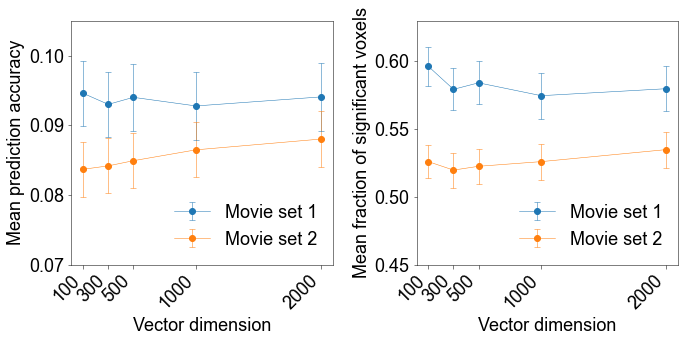

In [11]:
xlabels = vecsizes
grp_labels = ["Movie set 1", "Movie set 2"]

fig = plt.figure(figsize=(10, 5))

ax = plt.subplot(1, 2, 1)

x = vecsizes
y = np.vstack([mov1_acc.mean(axis=1), mov2_acc.mean(axis=1)]).T
e = np.vstack([mov1_acc.std(axis=1, ddof=1) / np.sqrt(mov1_acc.shape[1]), mov2_acc.std(axis=1, ddof=1) / np.sqrt(mov2_acc.shape[1])]).T
for i in range(2):
    ax.errorbar(x, y[:, i], yerr=e[:, i], marker="o", c=mpl.cm.tab10(i), lw=.5, capthick=.5, capsize=3)

ax.legend(grp_labels, loc="lower right", frameon=False)

ax.set_xlabel("Vector dimension")
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=45, ha="right")
ax.set_ylim([0.07, 0.105])
ax.set_ylabel("Mean prediction accuracy")

print("Change from min to max")
print("  Mean prediction accuracy: {:.3g}%".format((y.max() - y.min()) / y.min() * 100))

##

ax = plt.subplot(1, 2, 2)

x = vecsizes
y = np.vstack([mov1_fracsig.mean(axis=1), mov2_fracsig.mean(axis=1)]).T
e = np.vstack([mov1_fracsig.std(axis=1, ddof=1) / np.sqrt(mov1_fracsig.shape[1]), mov2_fracsig.std(axis=1, ddof=1) / np.sqrt(mov2_fracsig.shape[1])]).T
for i in range(2):
    ax.errorbar(x, y[:, i], yerr=e[:, i], marker="o", c=mpl.cm.tab10(i), lw=.5, capthick=.5, capsize=3)

ax.legend(grp_labels, loc="lower right", frameon=False)

ax.set_xlabel("Vector dimension")
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=45, ha="right")
ax.set_ylim([0.45, 0.63])
ax.set_ylabel("Mean fraction of significant voxels")

print("  Mean fraction of significant voxels: {:.3g}%".format((y.max() - y.min()) / y.min() * 100))

plt.tight_layout()
plt.show()

##

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, 'model_acc_all.pdf'))
pp.savefig(fig, dpi=300, bbox_inches='tight')
pp.close()

### Comparison across vector dimensions

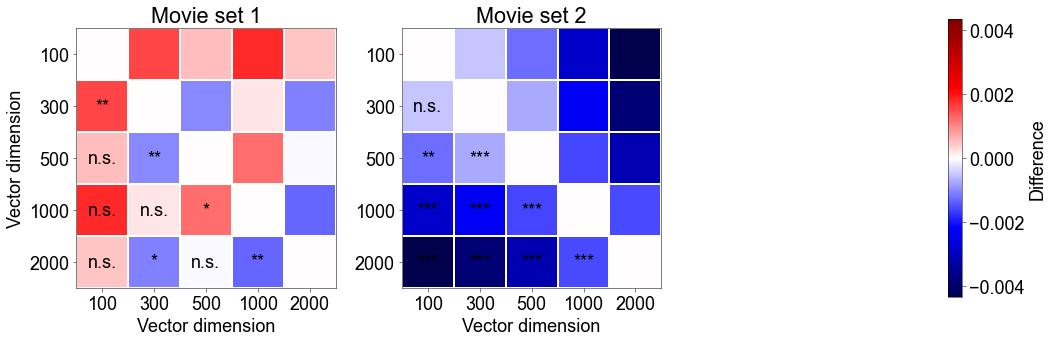

In [12]:
pairs = list(itertools.combinations(range(n_vecsizes), 2))
var_names = ["mov1_acc", "mov2_acc"]

diff_vals = []
corr_pvals = []
for i, name in enumerate(var_names):
    diff_vals.append([eval(name)[x[0]].mean() - eval(name)[x[1]].mean() for x in pairs])
    pvals = [stats.wilcoxon(eval(name)[x[0]], eval(name)[x[1]])[1] for x in pairs]
    corr_pvals.append(fdrcorrection(pvals, alpha=thresh_alpha)[1])

max_val = np.max([np.abs(np.max(diff_vals)), np.abs(np.min(diff_vals))])
min_val = -max_val

##
# Plot
cm = "seismic"
mk_col = "k"

fig = plt.figure(figsize=(15, 5))

for i, (vals, ps) in enumerate(zip(diff_vals, corr_pvals)):
    
    ax = plt.subplot(1, 3, i + 1)
    ax.pcolor(distance.squareform(vals), vmin=min_val, vmax=max_val, cmap=cm, ec="w", lw=1)
    ax.axis("square")
    
    for j, p in enumerate(pairs):
        mk = ""
        if ps[j] < 0.0001:
            mk = "***"
        elif ps[j] < 0.01:
            mk = "**"
        elif ps[j] < 0.05:
            mk = "*"
        elif ps[j] > 0.05:
            mk = "n.s."
        
        if mk is not "":
            ax.text(p[0] + .5, p[1] + .5, mk, c=mk_col, ha="center", va="center")
    
    ax.set_xticks(np.arange(n_vecsizes) + .5)
    ax.set_xticklabels(vecsizes)
    ax.set_xlabel("Vector dimension")
    
    ax.invert_yaxis()
    ax.set_yticks(np.arange(n_vecsizes) + .5)
    ax.set_yticklabels(vecsizes)
    if i == 0:
        ax.set_ylabel("Vector dimension")
        
    if i == 0:
        ax.set_title("Movie set 1")
    elif i == 1:
        ax.set_title("Movie set 2")

# Colorbar

ax = plt.subplot(1, 3, 3)

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

mappable = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(mappable, ax=ax, orientation="vertical", panchor=(0, 0))
cbar.set_label("Difference")

plt.tight_layout()
plt.show()

##

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, 'pred_acc_cmpr.pdf'))
pp.savefig(fig, dpi=300, bbox_inches='tight')
pp.close()

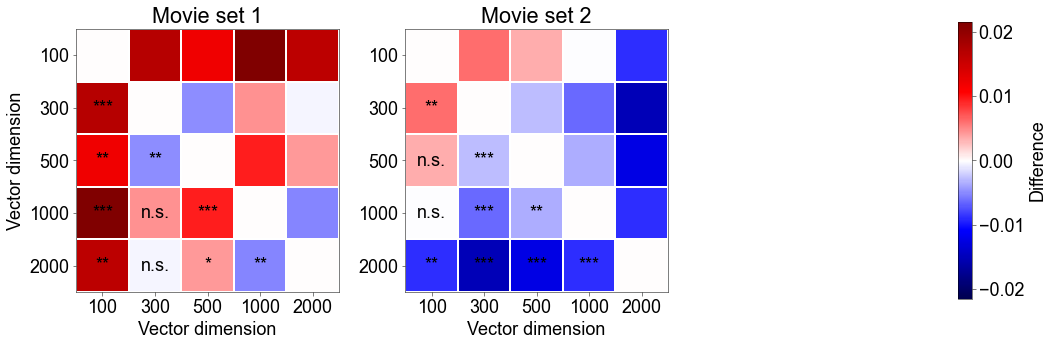

In [13]:
pairs = list(itertools.combinations(range(n_vecsizes), 2))
var_names = ["mov1_fracsig", "mov2_fracsig"]

diff_vals = []
corr_pvals = []
for i, name in enumerate(var_names):
    diff_vals.append([eval(name)[x[0]].mean() - eval(name)[x[1]].mean() for x in pairs])
    pvals = [stats.wilcoxon(eval(name)[x[0]], eval(name)[x[1]])[1] for x in pairs]
    corr_pvals.append(fdrcorrection(pvals, alpha=thresh_alpha)[1])

max_val = np.max([np.abs(np.max(diff_vals)), np.abs(np.min(diff_vals))])
min_val = -max_val

##
# Plot
cm = "seismic"
mk_col = "k"

fig = plt.figure(figsize=(15, 5))

for i, (vals, ps) in enumerate(zip(diff_vals, corr_pvals)):
    
    ax = plt.subplot(1, 3, i + 1)
    ax.pcolor(distance.squareform(vals), vmin=min_val, vmax=max_val, cmap=cm, ec="w", lw=1)
    ax.axis("square")
    
    for j, p in enumerate(pairs):
        mk = ""
        if ps[j] < 0.0001:
            mk = "***"
        elif ps[j] < 0.01:
            mk = "**"
        elif ps[j] < 0.05:
            mk = "*"
        elif ps[j] > 0.05:
            mk = "n.s."
        
        if mk is not "":
            ax.text(p[0] + .5, p[1] + .5, mk, c=mk_col, ha="center", va="center")
    
    ax.set_xticks(np.arange(n_vecsizes) + .5)
    ax.set_xticklabels(vecsizes)
    ax.set_xlabel("Vector dimension")
    
    ax.invert_yaxis()
    ax.set_yticks(np.arange(n_vecsizes) + .5)
    ax.set_yticklabels(vecsizes)
    if i == 0:
        ax.set_ylabel("Vector dimension")
        
    if i == 0:
        ax.set_title("Movie set 1")
    elif i == 1:
        ax.set_title("Movie set 2")

# Colorbar

ax = plt.subplot(1, 3, 3)

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

m = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(m, ax=ax, orientation="vertical")
cbar.set_label("Difference")

plt.tight_layout()
plt.show()

##

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, 'frac_sig_cmpr.pdf'))
pp.savefig(fig, dpi=300, bbox_inches='tight')
pp.close()

## Figs. 4A–B, S2, and Table S2: Cortical mapping of model accuracy

### Cortical maps

Dimension = 100
mov1
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)


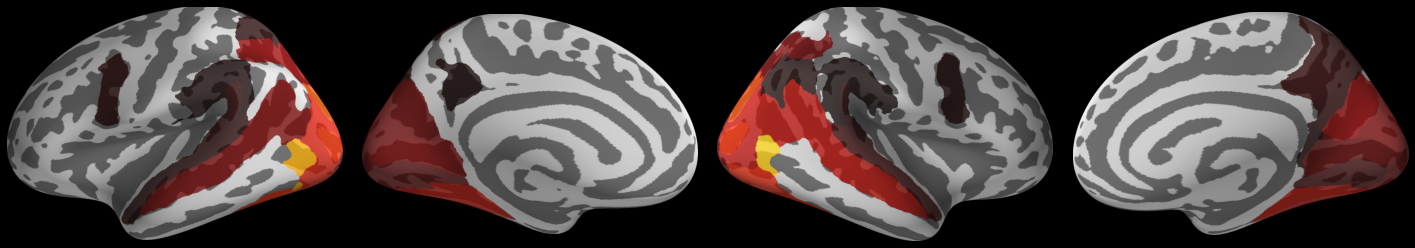

mov2
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)


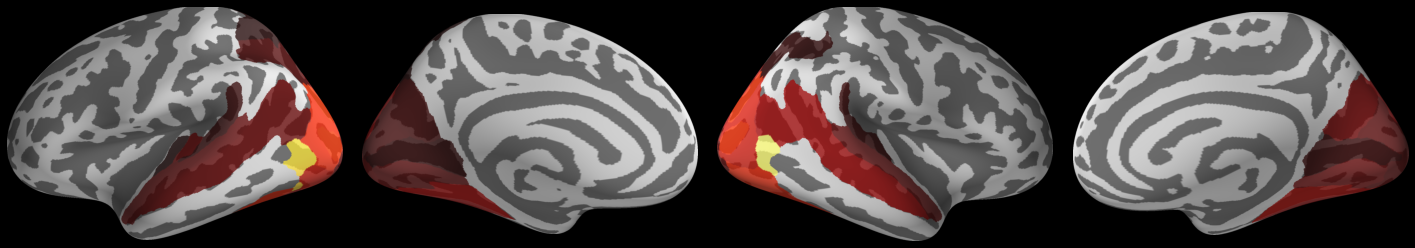

Dimension = 300
mov1
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)


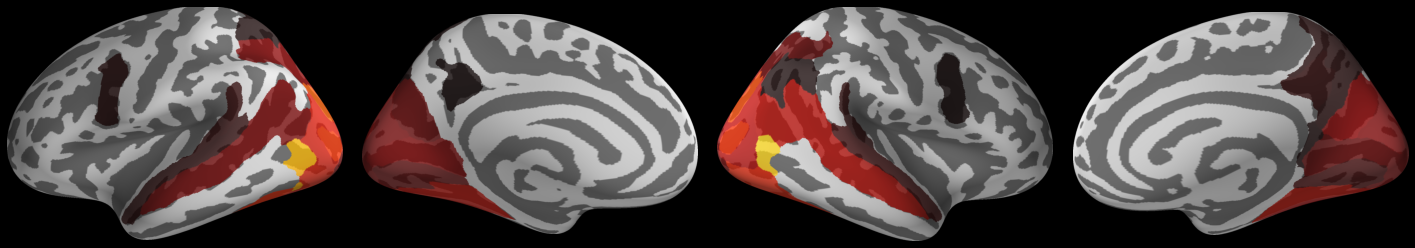

mov2
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)


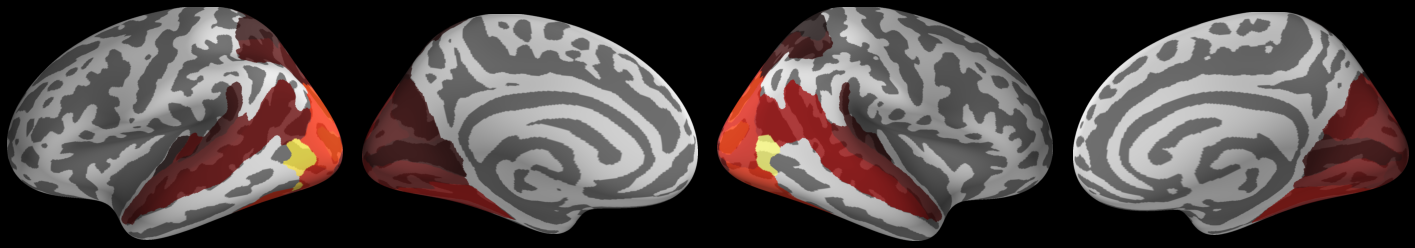

Dimension = 500
mov1
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)


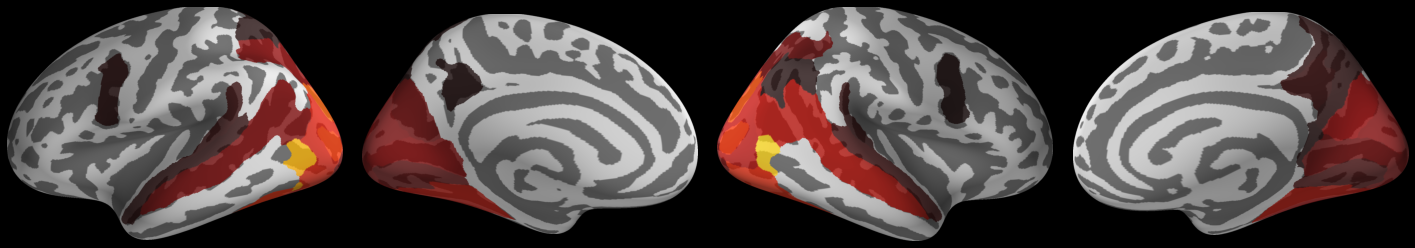

mov2
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)


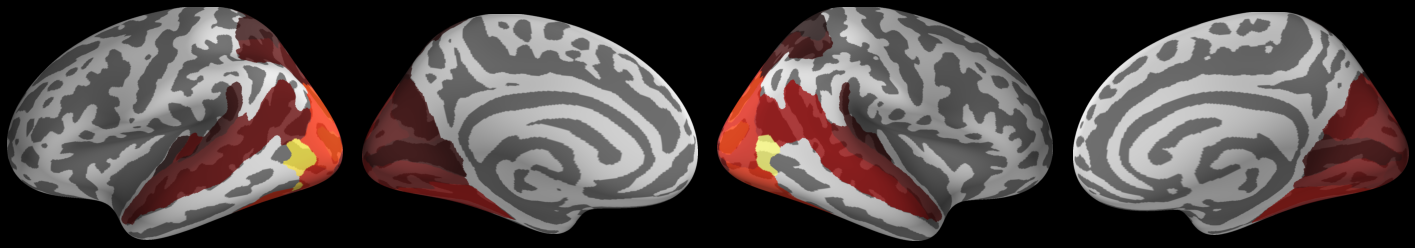

Dimension = 1000
mov1
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)


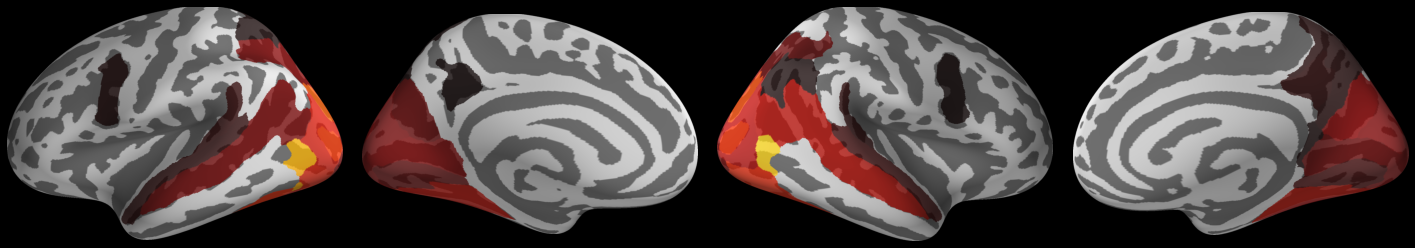

mov2
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)


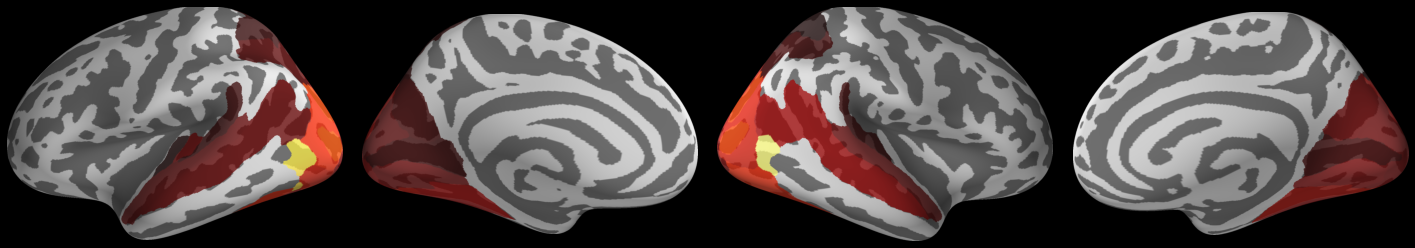

Dimension = 2000
mov1
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)


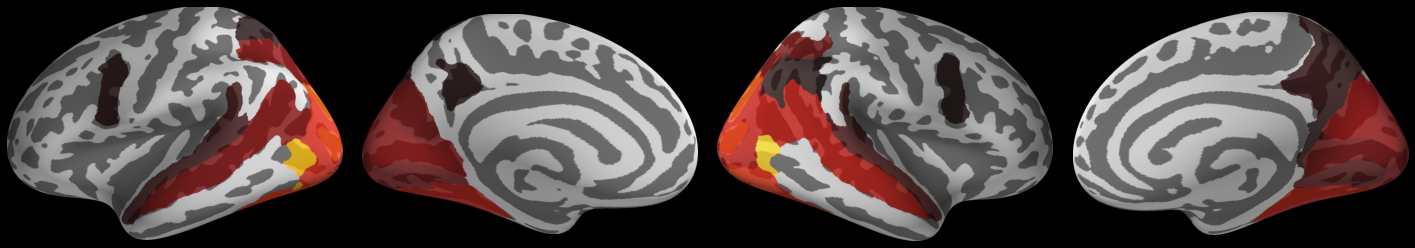

mov2
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)
colormap sequential: [1.10e-01, 2.38e-01, 3.65e-01] (opaque)


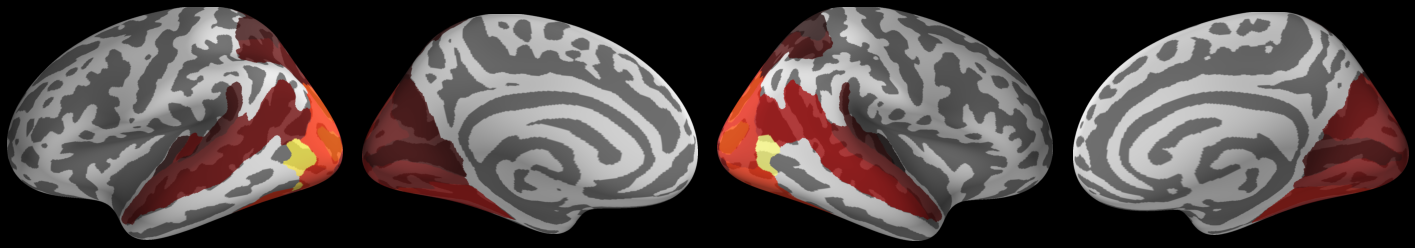

In [14]:
out_prefix = os.path.join(out_dir, "pred_acc_map")
mov_labels = ["mov1", "mov2"]

min_val = 0.11
max_val = np.max([mov1_roi_acc.mean(axis=2).max(), mov2_roi_acc.mean(axis=2).max()])

thresh_val = min_val
null_val = -1
cm = generate_cmap(mpl.cm.hot([0, 55, 110, 165, 220]))
alpha = .85

for vi, size in enumerate(vecsizes):
    print("Dimension = {}".format(size))
    
    for label in mov_labels:
        print(label)
        
        out_base = "{}_{}_{}".format(out_prefix, size, label)

        # Average over participants
        mean_vals = eval(label + "_roi_acc")[vi].mean(axis=1)

        # Get values for each ROI
        hemi_vals = np.zeros((2, n_hemi_rois)) - 1  # hemisphere x ROI
        for i in range(2):
            mask = roi_idx[i, :] != -1
            hemi_vals[i, mask] = mean_vals[roi_idx[i, mask]]        

        views = ["lat", "med"]

        for i, (hemi, labels) in enumerate(zip(["lh", "rh"], [lh_labels, rh_labels])):
            
            # Bring up the visualization.
            brain = Brain(subject_id, hemi, surf, background="black", subjects_dir=subjects_dir, size=1600)

            vtx_data = hemi_vals[i, labels]
            vtx_data[labels == -1] = null_val
            brain.add_data(vtx_data, min_val, max_val, thresh=thresh_val, colormap=cm, alpha=alpha,
                           colorbar=False, smoothing_steps=None)

            ## Save views
            for view in views:
                brain.show_view(view)
                fname = "{}_{}_{}.png".format(out_base, hemi, view)
                brain.save_image(fname)

                ## Trim
                cmd = 'mogrify -trim ' + fname
                subprocess.call(cmd.split())
                
            brain.close()

        ### Show images
        fig = plt.figure(figsize=(20, 5), facecolor="k")

        i = 1

        for hemi in ["lh", "rh"]:
            for view in views:
                img = np.array(Image.open("{}_{}_{}.png".format(out_base, hemi, view)))
                ax = fig.add_subplot(1, 4, i)
                ax.imshow(img)
                ax.axis("off")
                i += 1

        plt.tight_layout()
        plt.show()

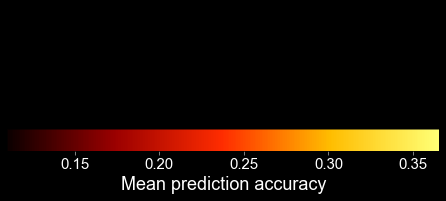

In [15]:
# Colorbar

out_name = out_prefix + "_colbar.pdf"

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

fig = plt.figure(facecolor="k")
ax = fig.add_axes((0, 0, 1, 1/3))

mappable = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(mappable, ax=ax, orientation="horizontal")
cbar.set_label("Mean prediction accuracy", color="w")
cbar.ax.spines["bottom"].set_color("w")
cbar.ax.spines["top"].set_color("w")
cbar.ax.spines["left"].set_color("w")
cbar.ax.spines["right"].set_color("w")
cbar.ax.xaxis.label.set_color("w")
cbar.ax.yaxis.label.set_color("w")
cbar.ax.tick_params(axis="x", colors="w", labelsize=15)
cbar.ax.tick_params(axis="y", colors="w")

pp = PdfPages(out_name)
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="black")
pp.close()

### Correlation between movie sets and between vector dimensions

In [16]:
mean_vals = np.vstack([mov1_roi_acc.mean(axis=2), mov2_roi_acc.mean(axis=2)])
coefs = 1 - distance.pdist(mean_vals, metric="correlation")

labels = np.hstack([["Movie set 1, {}".format(x) for x in vecsizes], ["Movie set 2, {}".format(x) for x in vecsizes]])
pd.DataFrame(distance.squareform(coefs), index=labels, columns=labels)

Movie set 1, 100  Movie set 1, 300  Movie set 1, 500  \
Movie set 1, 100           0.000000          0.999230          0.999360   
Movie set 1, 300           0.999230          0.000000          0.999916   
Movie set 1, 500           0.999360          0.999916          0.000000   
Movie set 1, 1000          0.998798          0.999892          0.999844   
Movie set 1, 2000          0.998545          0.999774          0.999681   
Movie set 2, 100           0.968652          0.972550          0.970767   
Movie set 2, 300           0.968293          0.972579          0.970717   
Movie set 2, 500           0.967679          0.972065          0.970179   
Movie set 2, 1000          0.967733          0.972358          0.970442   
Movie set 2, 2000          0.967585          0.972244          0.970344   

                   Movie set 1, 1000  Movie set 1, 2000  Movie set 2, 100  \
Movie set 1, 100            0.998798           0.998545          0.968652   
Movie set 1, 300            0.999892           0.999774          0.972550   
Movie set 1, 500            0.999844           0.999681          0.970767   
Movie set 1, 1000           0.000000           0.999909          0.972929   
Movie set 1, 2000           0.999909           0.000000          0.973938   
Movie set 2, 100            0.972929           0.973938          0.000000   
Movie set 2, 300            0.973041           0.974143          0.999682   
Movie set 2, 500            0.972544           0.973681          0.999564   
Movie set 2, 1000           0.972887           0.974049          0.999167   
Movie set 2, 2000           0.972808           0.973986          0.999034   

                   Movie set 2, 300  Movie set 2, 500  Movie set 2, 1000  \
Movie set 1, 100           0.968293          0.967679           0.967733   
Movie set 1, 300           0.972579          0.972065           0.972358   
Movie set 1, 500           0.970717          0.970179           0.970442   
Movie set 1, 1000          0.973041          0.972544           0.972887   
Movie set 1, 2000          0.974143          0.973681           0.974049   
Movie set 2, 100           0.999682          0.999564           0.999167   
Movie set 2, 300           0.000000          0.999945           0.999817   
Movie set 2, 500           0.999945          0.000000           0.999893   
Movie set 2, 1000          0.999817          0.999893           0.000000   
Movie set 2, 2000          0.999700          0.999824           0.999949   

                   Movie set 2, 2000  
Movie set 1, 100            0.967585  
Movie set 1, 300            0.972244  
Movie set 1, 500            0.970344  
Movie set 1, 1000           0.972808  
Movie set 1, 2000           0.973986  
Movie set 2, 100            0.999034  
Movie set 2, 300            0.999700  
Movie set 2, 500            0.999824  
Movie set 2, 1000           0.999949  
Movie set 2, 2000           0.000000

## Figs. 4C–D, S3, and Talble S3: Cortical mapping of fraction of significant voxels

### Cortical maps

Dimension = 100
mov1
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)


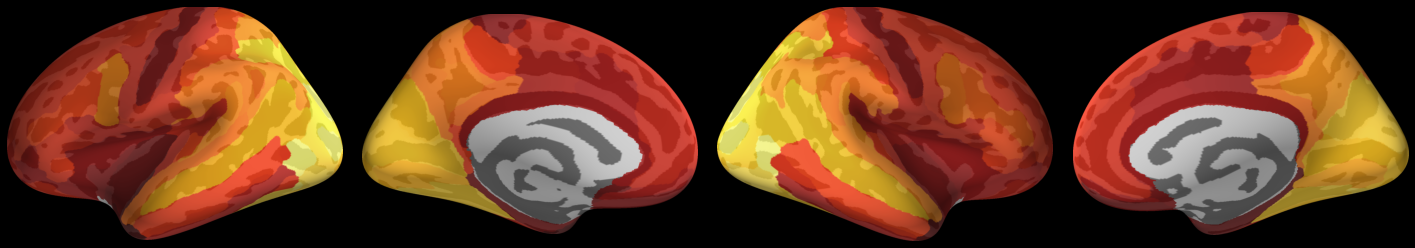

mov2
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)


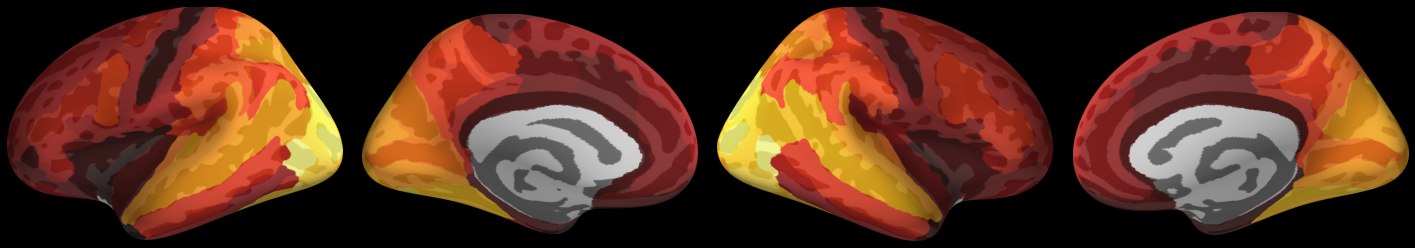

Dimension = 300
mov1
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)


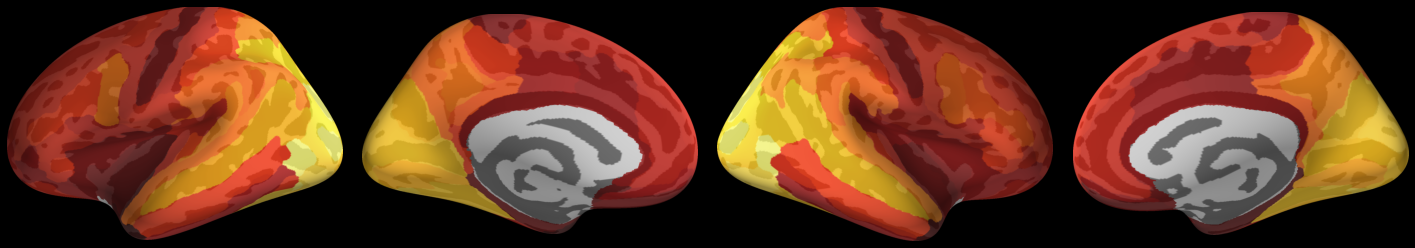

mov2
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)


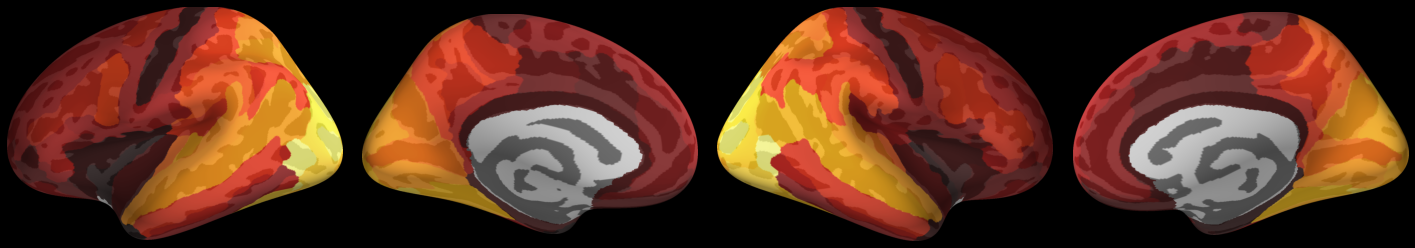

Dimension = 500
mov1
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)


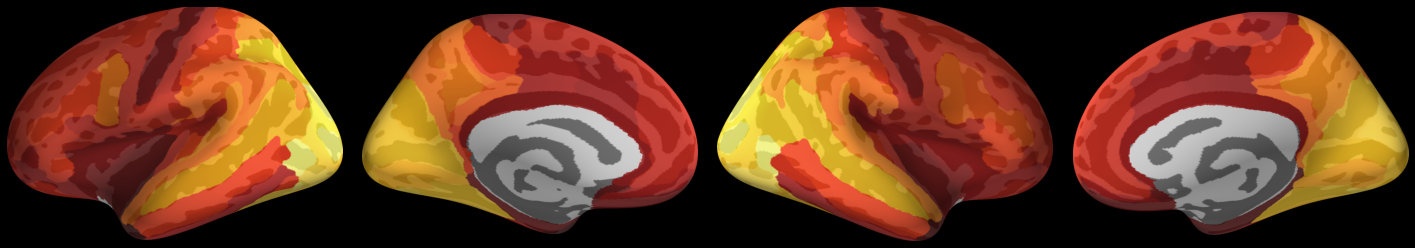

mov2
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)


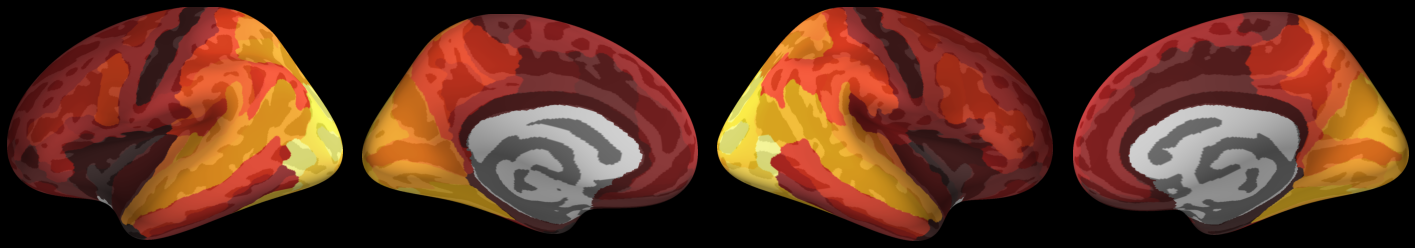

Dimension = 1000
mov1
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)


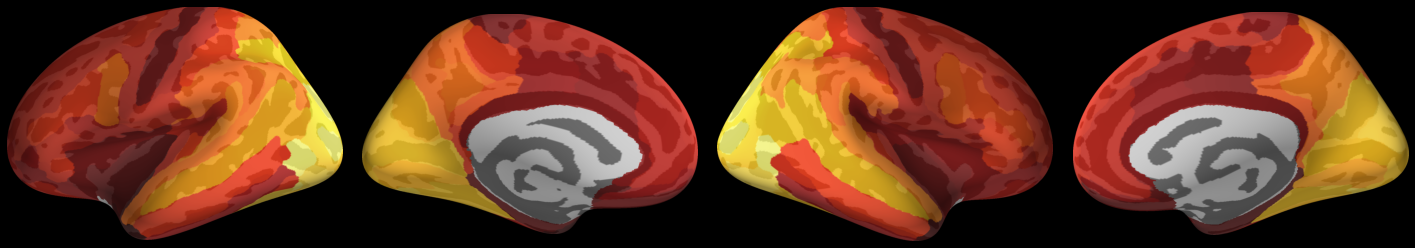

mov2
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)


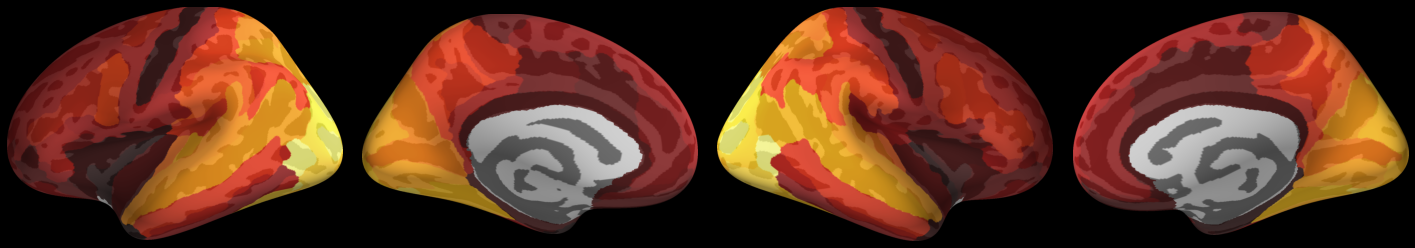

Dimension = 2000
mov1
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)


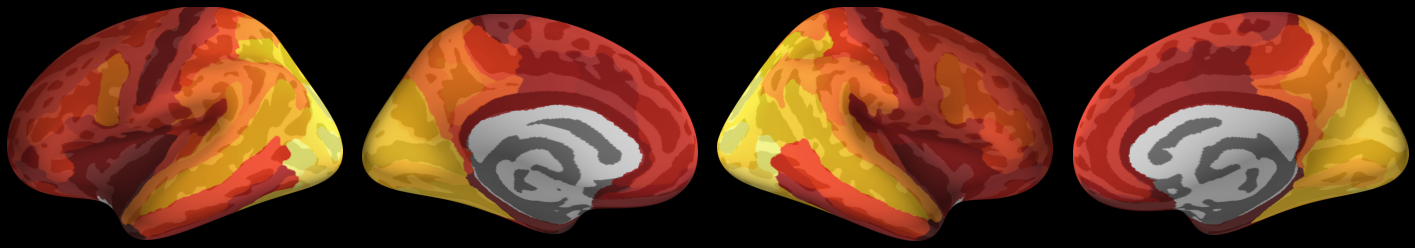

mov2
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)
colormap sequential: [2.37e-01, 6.03e-01, 9.69e-01] (opaque)


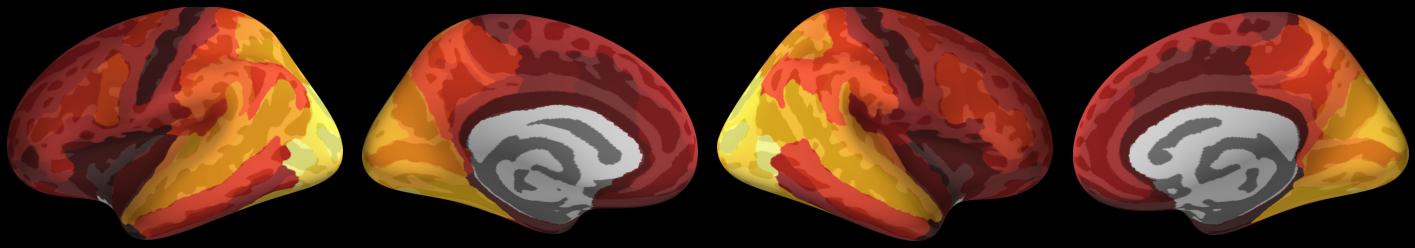

In [18]:
# Significance
mov1_rejected = np.zeros((n_vecsizes, n_roi_names))
mov2_rejected = np.zeros((n_vecsizes, n_roi_names))

for mov in ["mov1", "mov2"]:
    for vi in range(n_vecsizes):
        
        pvals = np.ones(n_roi_names)
        for ri in range(n_roi_names):
            if np.any(eval(mov + "_roi_fracsig")[vi, ri] != 0):
                pvals[ri] = stats.wilcoxon(eval(mov + "_roi_fracsig")[vi, ri])[1]
        
        eval(mov + "_rejected")[vi] = fdrcorrection(pvals, 0.05)[0]

###
# Make mapes

out_prefix = os.path.join(out_dir, "fracsig_map")
mov_labels = ["mov1", "mov2"]

mask = np.any(mov1_roi_fracsig.mean(axis=2) != 0, axis=0)
min_val = np.min([mov1_roi_fracsig.mean(axis=2)[:, mask].min(), mov2_roi_fracsig.mean(axis=2)[:, mask].min()])
max_val = np.max([mov1_roi_fracsig.mean(axis=2)[:, mask].max(), mov2_roi_fracsig.mean(axis=2)[:, mask].max()])

thresh_val = min_val
null_val = -1
cm = generate_cmap(mpl.cm.hot([0, 55, 110, 165, 220]))
alpha = .85


for vi, size in enumerate(vecsizes):
    print("Dimension = {}".format(size))
    
    for label in mov_labels:
        print(label)
        
        out_base = "{}_{}_{}".format(out_prefix, size, label)

        # Average over participants
        mean_vals = eval(label + "_roi_fracsig")[vi].mean(axis=1)

        # Get values for each ROI
        hemi_vals = np.zeros((2, n_hemi_rois)) - 1  # hemisphere x ROI
        for i in range(2):
            mask = np.logical_and(roi_idx[i, :] != -1, eval(label + "_rejected")[vi, roi_idx[i, :]])
            hemi_vals[i, mask] = mean_vals[roi_idx[i, mask]]

        views = ["lat", "med"]

        for i, (hemi, labels) in enumerate(zip(["lh", "rh"], [lh_labels, rh_labels])):
            
            # Bring up the visualization.
            brain = Brain(subject_id, hemi, surf, background="black", subjects_dir=subjects_dir, size=1600)

            vtx_data = hemi_vals[i, labels]
            vtx_data[labels == -1] = null_val
            brain.add_data(vtx_data, min_val, max_val, thresh=thresh_val, colormap=cm, alpha=alpha,
                           colorbar=False, smoothing_steps=None)

            ## Save views
            for view in views:
                brain.show_view(view)
                fname = "{}_{}_{}.png".format(out_base, hemi, view)
                brain.save_image(fname)

                ## Trim
                cmd = 'mogrify -trim ' + fname
                subprocess.call(cmd.split())
                
            brain.close()

        ### Show images
        fig = plt.figure(figsize=(20, 5), facecolor="k")

        i = 1

        for hemi in ["lh", "rh"]:
            for view in views:
                img = np.array(Image.open("{}_{}_{}.png".format(out_base, hemi, view)))
                ax = fig.add_subplot(1, 4, i)
                ax.imshow(img)
                ax.axis("off")
                i += 1

        plt.tight_layout()
        plt.show()

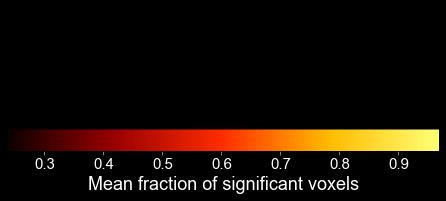

In [19]:
# Colorbar

out_name = out_prefix + "_colbar.pdf"

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

fig = plt.figure(facecolor="k")
ax = fig.add_axes((0, 0, 1, 1/3))

mappable = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(mappable, ax=ax, orientation="horizontal")
cbar.set_label("Mean fraction of significant voxels", color="w")
cbar.ax.spines["bottom"].set_color("w")
cbar.ax.spines["top"].set_color("w")
cbar.ax.spines["left"].set_color("w")
cbar.ax.spines["right"].set_color("w")
cbar.ax.xaxis.label.set_color("w")
cbar.ax.yaxis.label.set_color("w")
cbar.ax.tick_params(axis="x", colors="w", labelsize=15)
cbar.ax.tick_params(axis="y", colors="w")

pp = PdfPages(out_name)
pp.savefig(fig, dpi=300, bbox_inches="tight", facecolor="black")
pp.close()

### Correlation between movie sets and between vector dimensions

In [20]:
mean_vals = np.vstack([mov1_roi_fracsig.mean(axis=2), mov2_roi_fracsig.mean(axis=2)])
coefs = 1 - distance.pdist(mean_vals, metric="correlation")

labels = np.hstack([["Movie set 1, {}".format(x) for x in vecsizes], ["Movie set 2, {}".format(x) for x in vecsizes]])
pd.DataFrame(distance.squareform(coefs), index=labels, columns=labels)

Movie set 1, 100  Movie set 1, 300  Movie set 1, 500  \
Movie set 1, 100           0.000000          0.999124          0.999250   
Movie set 1, 300           0.999124          0.000000          0.999863   
Movie set 1, 500           0.999250          0.999863          0.000000   
Movie set 1, 1000          0.998506          0.999749          0.999667   
Movie set 1, 2000          0.998322          0.999575          0.999489   
Movie set 2, 100           0.957571          0.963703          0.961212   
Movie set 2, 300           0.957821          0.964421          0.961915   
Movie set 2, 500           0.958234          0.964842          0.962356   
Movie set 2, 1000          0.958940          0.965543          0.963110   
Movie set 2, 2000          0.959949          0.966317          0.963932   

                   Movie set 1, 1000  Movie set 1, 2000  Movie set 2, 100  \
Movie set 1, 100            0.998506           0.998322          0.957571   
Movie set 1, 300            0.999749           0.999575          0.963703   
Movie set 1, 500            0.999667           0.999489          0.961212   
Movie set 1, 1000           0.000000           0.999843          0.965018   
Movie set 1, 2000           0.999843           0.000000          0.966503   
Movie set 2, 100            0.965018           0.966503          0.000000   
Movie set 2, 300            0.965931           0.967253          0.999535   
Movie set 2, 500            0.966341           0.967688          0.999435   
Movie set 2, 1000           0.967048           0.968380          0.999098   
Movie set 2, 2000           0.967726           0.969125          0.998939   

                   Movie set 2, 300  Movie set 2, 500  Movie set 2, 1000  \
Movie set 1, 100           0.957821          0.958234           0.958940   
Movie set 1, 300           0.964421          0.964842           0.965543   
Movie set 1, 500           0.961915          0.962356           0.963110   
Movie set 1, 1000          0.965931          0.966341           0.967048   
Movie set 1, 2000          0.967253          0.967688           0.968380   
Movie set 2, 100           0.999535          0.999435           0.999098   
Movie set 2, 300           0.000000          0.999924           0.999794   
Movie set 2, 500           0.999924          0.000000           0.999878   
Movie set 2, 1000          0.999794          0.999878           0.000000   
Movie set 2, 2000          0.999553          0.999713           0.999889   

                   Movie set 2, 2000  
Movie set 1, 100            0.959949  
Movie set 1, 300            0.966317  
Movie set 1, 500            0.963932  
Movie set 1, 1000           0.967726  
Movie set 1, 2000           0.969125  
Movie set 2, 100            0.998939  
Movie set 2, 300            0.999553  
Movie set 2, 500            0.999713  
Movie set 2, 1000           0.999889  
Movie set 2, 2000           0.000000

## Figs. 4 and S5: Correlation between behavioral and modeled dissimilarity

In [21]:
noun_dissim = np.zeros((4, behav_noun_dissim.shape[0]))
adj_dissim = np.zeros((4, behav_adj_dissim.shape[0]))

noun_dissim[0] = behav_noun_dissim
adj_dissim[0] = behav_adj_dissim

for i, p in enumerate(["wv", "mov1", "mov2"]):
    noun_dissim[i + 1] = eval(p + "_noun_dissim")[dim_idx]
    adj_dissim[i + 1] = eval(p + "_adj_dissim")[dim_idx]
    
print("Mean number of noun trials: mean ± SD = {} ± {}".format(noun_n_trials.mean(), noun_n_trials.std(ddof=1)))
print("Mean number of adjective trials: mean ± SD = {} ± {}".format(adj_n_trials.mean(), adj_n_trials.std(ddof=1)))

tmp = np.concatenate([noun_n_trials, adj_n_trials])
print("Mean number of either trials: mean ± SD = {} ± {}".format(tmp.mean(), tmp.std(ddof=1)))

Mean number of noun trials: mean ± SD = 17.27777777777778 ± 8.719800492839308
Mean number of adjective trials: mean ± SD = 20.305555555555557 ± 12.265676719888935
Mean number of either trials: mean ± SD = 18.791666666666668 ± 10.67567657914641


### Dissimilarity matrix

Dimension = 1000
Noun
Adjective


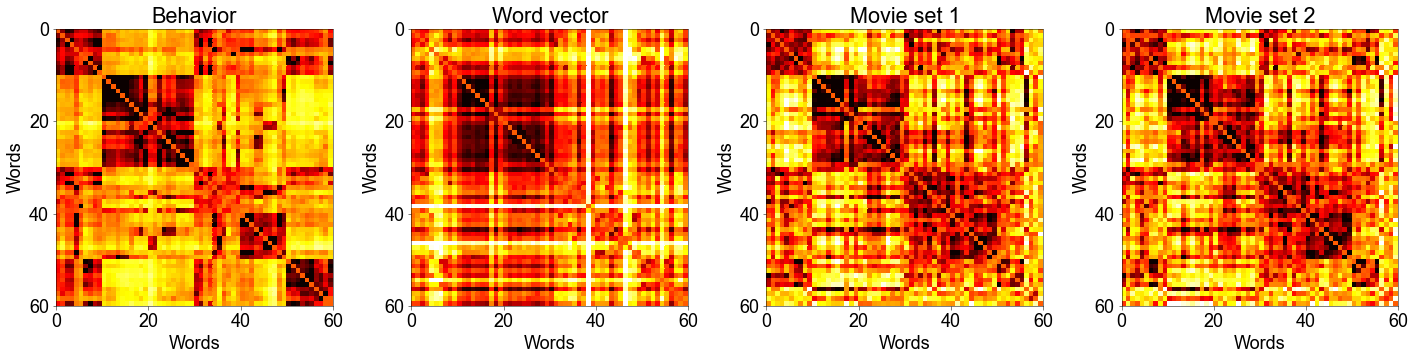

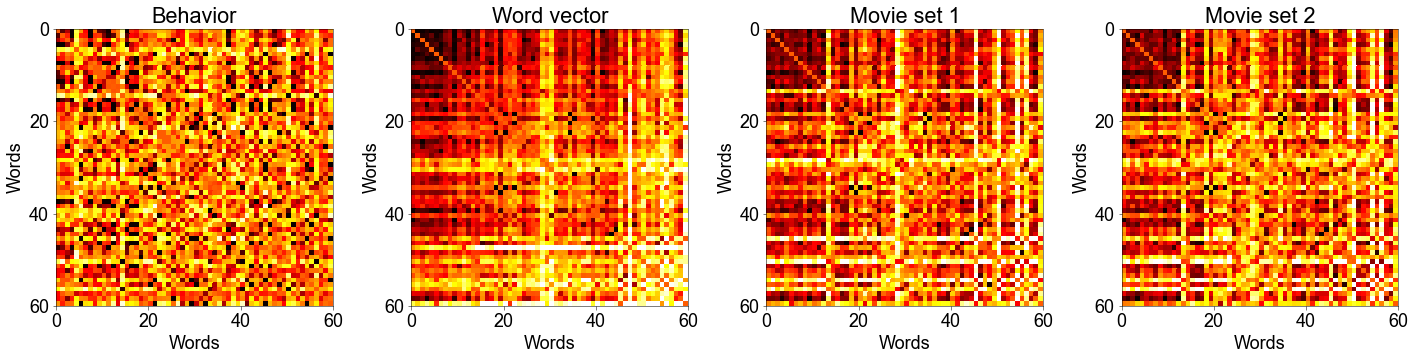

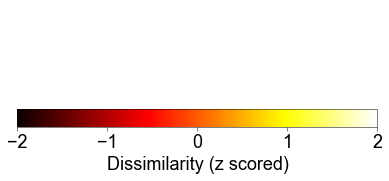

In [22]:
print("Dimension = {}".format(vecsizes[dim_idx]))

prefixes = ["behav", "wv", "mov1", "mov2"]
titles = ["Behavior", "Word vector", "Movie set 1", "Movie set 2"]

min_val = -2
max_val = 2

# Noun

print("Noun")

fig = plt.figure(figsize=(20, 5))

for i, (p, t) in enumerate(zip(prefixes, titles)):
    ax = plt.subplot(1, 4, i + 1)
    ax.pcolor(distance.squareform(noun_dissim[i]), vmin=min_val, vmax=max_val, cmap="hot")
    ax.axis("square")

    ax.set_xlabel("Words")
    ax.set_xticks(np.linspace(0, 60, 4))
    ax.invert_yaxis()
    ax.set_ylabel("Words")
    ax.set_yticks(np.linspace(0, 60, 4))
    ax.set_title(t)

plt.tight_layout()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "dissim_mat_noun.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight")
pp.close()

##
# Adjective

print("Adjective")

fig = plt.figure(figsize=(20, 5))

for i, (p, t) in enumerate(zip(prefixes, titles)):
    ax = plt.subplot(1, 4, i + 1)
    ax.pcolor(distance.squareform(adj_dissim[i]), vmin=min_val, vmax=max_val, cmap="hot")
    ax.axis("square")

    ax.set_xlabel("Words")
    ax.set_xticks(np.linspace(0, 60, 4))
    ax.invert_yaxis()
    ax.set_ylabel("Words")
    ax.set_yticks(np.linspace(0, 60, 4))
    ax.set_title(t)

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "dissim_mat_adj.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight")
pp.close()

##
# Color bar

# Colorbar
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes((0, 0, 1, 1/3))

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

m = ax.pcolor(X, Y, Z, cmap="hot", vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(m, ax=ax, orientation="horizontal")
cbar.set_label("Dissimilarity (z scored)")

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, "dissim_mat_colorbar.pdf"))
pp.savefig(fig, dpi=300, bbox_inches="tight")
pp.close()

### Correlation

In [23]:
print("Dimension = {}".format(vecsizes[dim_idx]))

print("Noun:")

coef, pval = stats.pearsonr(noun_dissim[0], noun_dissim[1])
print(" Behav & WV: r = {}, p = {}".format(coef, pval))

coef, pval = stats.pearsonr(noun_dissim[0], noun_dissim[2])
print(" Behav & Mov1: r = {}, p = {}".format(coef, pval))

coef, pval = stats.pearsonr(noun_dissim[0], noun_dissim[3])
print(" Behav & Mov2: r = {}, p = {}".format(coef, pval))

coef, pval = stats.pearsonr(noun_dissim[2], noun_dissim[3])
print(" Mov1 & Mov2: r = {}, p = {}".format(coef, pval))

print("Adjective:")

coef, pval = stats.pearsonr(adj_dissim[0], adj_dissim[1])
print(" Behav & Mov1: r = {}, p = {}".format(coef, pval))

coef, pval = stats.pearsonr(adj_dissim[0], adj_dissim[2])
print(" Behav & Mov2: r = {}, p = {}".format(coef, pval))

coef, pval = stats.pearsonr(adj_dissim[0], adj_dissim[3])
print(" Mov1 & Mov2: r = {}, p = {}".format(coef, pval))

coef, pval = stats.pearsonr(adj_dissim[2], adj_dissim[3])
print(" Behav & WV: r = {}, p = {}".format(coef, pval))

Dimension = 1000
Noun:
 Behav & WV: r = 0.3181804214654195, p = 6.235848614624263e-43
 Behav & Mov1: r = 0.6116013180826206, p = 4.251271925369135e-182
 Behav & Mov2: r = 0.634854404203053, p = 2.5740197833719452e-200
 Mov1 & Mov2: r = 0.9318474165833237, p = 0.0
Adjective:
 Behav & Mov1: r = 0.25036376574304653, p = 1.056903307344882e-26
 Behav & Mov2: r = 0.3417803281989812, p = 1.1291939054200029e-49
 Mov1 & Mov2: r = 0.35781832075903464, p = 1.3318170253718547e-54
 Behav & WV: r = 0.9361218899275676, p = 0.0


### Correlation for all vector dimensions

In [24]:
# Correlation with behavior

n_vecsizes = mov1_noun_dissim.shape[0]

br_coefs = np.zeros((2, 2, n_vecsizes))  # POS x movie set x dimension
br_pvals = np.ones((2, 2, n_vecsizes))

wv_coefs = np.zeros((2, n_vecsizes))  # POS x dimension
wv_pvals = np.zeros((2, n_vecsizes))

pos = ["noun", "adj"]

n_nouns = len(nouns)
n_word_pairs = int(n_nouns * (n_nouns - 1) / 2)

behav_dissim = np.zeros((2, n_word_pairs))  # POS x word pair
brain_dissim = np.zeros((2, 2, n_vecsizes, n_word_pairs))  # Movie set x POS x dimension x word pair
wv_dissim = np.zeros((2, n_vecsizes, n_word_pairs))  # POS x dimension x word pair

for i in range(2):
    
    behav_dissim[i] = eval("behav_" + pos[i] + "_dissim")
    
    wv_dissim[i] = eval("wv_" + pos[i] + "_dissim")
    for vi in range(n_vecsizes):
        wv_coefs[i, vi], wv_pvals[i, vi] = stats.pearsonr(wv_dissim[i, vi], behav_dissim[i])
    
    for j in range(2):
        for vi in range(n_vecsizes):
            brain_dissim[i, j, vi] = eval("mov" + str(j + 1) + "_" + pos[i] + "_dissim")[vi]
            br_coefs[i, j, vi], br_pvals[i, j, vi] = stats.pearsonr(brain_dissim[i, j, vi], behav_dissim[i])

### Bootstrapping

In [25]:
pairs = list(itertools.combinations(range(n_vecsizes), 2))
n_pairs = len(pairs)

n_itrs = 10000

br_boot_ci95 = np.zeros((2, 2, n_vecsizes, 2))  # POS x movie set x dimension x lower/upper
br_boot_pvals = np.ones((2, 2, n_pairs))  # POS x movie set x dimension pair

wv_boot_ci95 = np.zeros((2, n_vecsizes, 2))  # POS x dimension x lower/upper
br_wv_boot_pvals = np.ones((2, 2, n_vecsizes))  # POS x movie set x dimensions

for i in range(2):
    print(pos[i])
    xsamps = behav_dissim[i]
    zsamps = wv_dissim[i]
    
    for j in range(2):
        print("mov" + str(j + 1))
        ysamps = brain_dissim[i, j]
        
        xy_r_samps = np.zeros((n_itrs, n_vecsizes))
        xz_r_samps = np.zeros((n_itrs, n_vecsizes))
        yy_diff_samps = np.zeros((n_itrs, n_pairs))
        yz_diff_samps = np.zeros((n_itrs, n_vecsizes))
        
        # Bootstrapping
        for bi in range(n_itrs):
            
            # Resample indices
            ids = np.random.choice(n_word_pairs, n_word_pairs, replace=True)
            
            xy_r_samps[bi] = [stats.pearsonr(xsamps[ids], y[ids])[0] for y in ysamps]
            xz_r_samps[bi] = [stats.pearsonr(xsamps[ids], z[ids])[0] for z in zsamps]
            
            yy_diff_samps[bi] = [xy_r_samps[bi][p[0]] - xy_r_samps[bi][p[1]] for p in pairs]
            yz_diff_samps[bi] = [xy_r_samps[bi][vi] - xz_r_samps[bi][vi] for vi in range(n_vecsizes)]
            
        # 95% confidence interval
        sort_r_samps = np.sort(xy_r_samps, axis=0)
        br_boot_ci95[i, j, :, 0] = br_coefs[i, j, :] - sort_r_samps[int(n_itrs * 0.025), :]  # Lower interval
        br_boot_ci95[i, j, :, 1] = sort_r_samps[int(n_itrs * 0.975), :] - br_coefs[i, j, :]  # Upper interval
        
        # 95% confidence interval
        sort_r_samps = np.sort(xz_r_samps, axis=0)
        wv_boot_ci95[i, :, 0] = wv_coefs[i, :] - sort_r_samps[int(n_itrs * 0.025), :]  # Lower interval
        wv_boot_ci95[i, :, 1] = sort_r_samps[int(n_itrs * 0.975), :] - wv_coefs[i, :]  # Upper interval
        
        # P value
        ps = np.sum(yy_diff_samps < 0, axis=0) / n_itrs
        ps[ps > 0.5] = 1 - ps[ps > 0.5]
        br_boot_pvals[i, j] = ps
        
        ps = np.sum(yz_diff_samps < 0, axis=0) / n_itrs
        ps[ps > 0.5] = 1 - ps[ps > 0.5]
        br_wv_boot_pvals[i, j] = ps

noun
mov1
mov2
adj
mov1
mov2


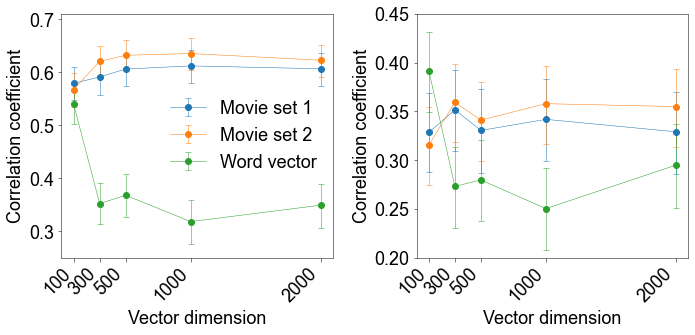

In [26]:
xlabels = vecsizes
grp_labels = ["Movie set 1", "Movie set 2", "Word vector"]

fig = plt.figure(figsize=(10, 5))

ax = plt.subplot(1, 2, 1)

x = vecsizes
y = br_coefs[0]
e = br_boot_ci95[0]
for i in range(2):
    ax.errorbar(x, y[i, :], yerr=e[i].T, marker="o", c=mpl.cm.tab10(i), lw=.5, capthick=.5, capsize=3)

y = wv_coefs[0]
e = wv_boot_ci95[0]
ax.errorbar(x, y, yerr=e.T, marker="o", c=mpl.cm.tab10(2), lw=.5, capthick=.5, capsize=3)

ax.legend(grp_labels, loc="right", frameon=False)

ax.set_xlabel("Vector dimension")
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=45, ha="right")
ax.set_ylim([0.25, 0.71])
ax.set_ylabel("Correlation coefficient")

##

ax = plt.subplot(1, 2, 2)

x = vecsizes
y = br_coefs[1]
e = br_boot_ci95[1]
for i in range(2):
    ax.errorbar(x, y[i, :], yerr=e[i].T, marker="o", c=mpl.cm.tab10(i), lw=.5, capthick=.5, capsize=3)

y = wv_coefs[1]
e = wv_boot_ci95[1]
ax.errorbar(x, y, yerr=e.T, marker="o", c=mpl.cm.tab10(2), lw=.5, capthick=.5, capsize=3)

ax.set_xlabel("Vector dimension")
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=45, ha="right")
ax.set_ylim([0.2, 0.45])
ax.set_ylabel("Correlation coefficient")

plt.tight_layout()
plt.show()

##

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, 'dissim_corr_all.pdf'))
pp.savefig(fig, dpi=300, bbox_inches='tight')
pp.close()

### Comparison between brain and word vectors

In [27]:
corr_pvals = fdrcorrection(br_wv_boot_pvals.ravel(), 0.05)[1]
corr_pvals = corr_pvals.reshape((2, 2, n_vecsizes))

for pi, pos in enumerate(["Noun", "Adjective"]):
    print(pos)
    
    for mi, mov in enumerate(["Mov1", "Mov2"]):
        print(" " + mov)
        
        for vi, size in enumerate(vecsizes):
            print("  {} dim: p = {:.3g}".format(size, corr_pvals[pi, mi, vi]))

Noun
 Mov1
  100 dim: p = 0.00556
  300 dim: p = 0
  500 dim: p = 0
  1000 dim: p = 0
  2000 dim: p = 0
 Mov2
  100 dim: p = 0.0315
  300 dim: p = 0
  500 dim: p = 0
  1000 dim: p = 0
  2000 dim: p = 0
Adjective
 Mov1
  100 dim: p = 0.000375
  300 dim: p = 0
  500 dim: p = 0.000588
  1000 dim: p = 0
  2000 dim: p = 0.0269
 Mov2
  100 dim: p = 0
  300 dim: p = 0
  500 dim: p = 0
  1000 dim: p = 0
  2000 dim: p = 0.000375


### Comparison across vector dimensions

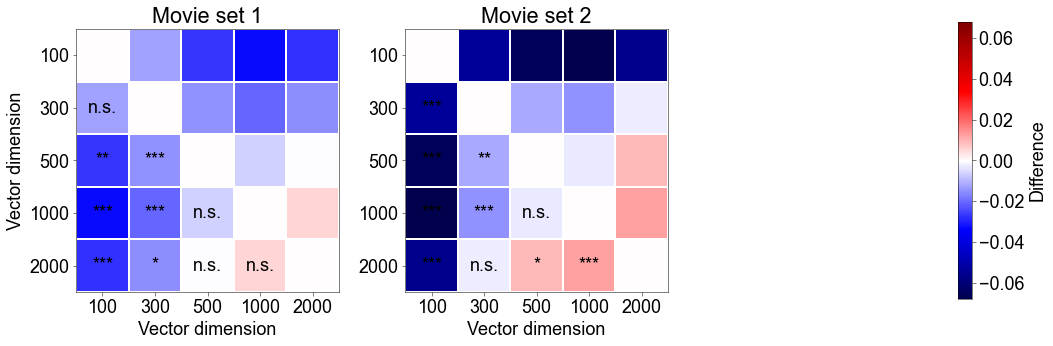

In [28]:
# Noun

pairs = list(itertools.combinations(range(n_vecsizes), 2))

n_noun_pairs = n_nouns * (n_nouns - 1) / 2

diff_vals = []
corr_pvals = []

for i in range(2):
    diff_vals.append([br_coefs[0, i, x[0]] - br_coefs[0, i, x[1]] for x in pairs])

    # FDR correction
    corr_pvals.append(fdrcorrection(br_boot_pvals[0, i], alpha=thresh_alpha)[1])

max_val = np.max([np.abs(np.max(diff_vals)), np.abs(np.min(diff_vals))])
min_val = -max_val

##
# Plot
cm = "seismic"
mk_col = "k"

fig = plt.figure(figsize=(15, 5))

for i, (vals, ps) in enumerate(zip(diff_vals, corr_pvals)):
    
    ax = plt.subplot(1, 3, i + 1)
    ax.pcolor(distance.squareform(vals), vmin=min_val, vmax=max_val, cmap=cm, ec="w", lw=1)
    ax.axis("square")
    
    for j, p in enumerate(pairs):
        mk = ""
        if ps[j] < 0.001:
            mk = "***"
        elif ps[j] < 0.01:
            mk = "**"
        elif ps[j] < 0.05:
            mk = "*"
        elif ps[j] > 0.05:
            mk = "n.s."
        
        if mk is not "":
            ax.text(p[0] + .5, p[1] + .5, mk, c=mk_col, ha="center", va="center")
    
    ax.set_xticks(np.arange(n_vecsizes) + .5)
    ax.set_xticklabels(vecsizes)
    ax.set_xlabel("Vector dimension")
    
    ax.invert_yaxis()
    ax.set_yticks(np.arange(n_vecsizes) + .5)
    ax.set_yticklabels(vecsizes)
    if i == 0:
        ax.set_ylabel("Vector dimension")
        
    if i == 0:
        ax.set_title("Movie set 1")
    elif i == 1:
        ax.set_title("Movie set 2")

# Colorbar

ax = plt.subplot(1, 3, 3)

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

mappable = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(mappable, ax=ax, orientation="vertical")
cbar.set_label("Difference")

plt.tight_layout()
plt.show()

##

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, 'dissim_corr_cmpr_noun.pdf'))
pp.savefig(fig, dpi=300, bbox_inches='tight')
pp.close()

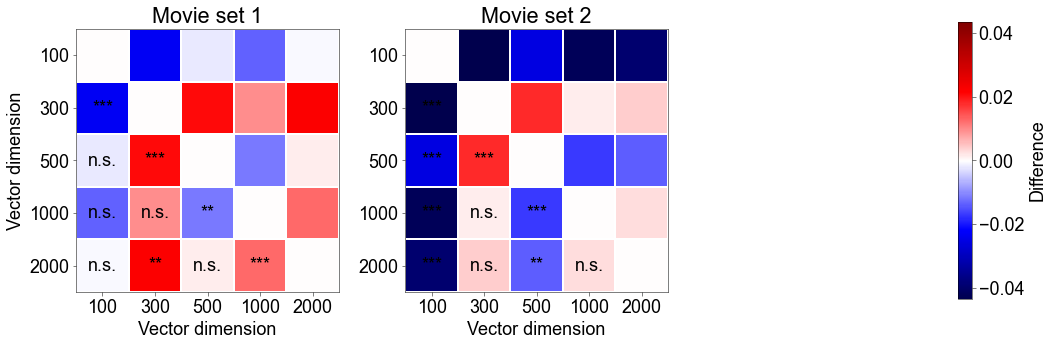

In [29]:
# Adjective

pairs = list(itertools.combinations(range(n_vecsizes), 2))

n_adjs = len(adjs)
n_adj_pairs = n_adjs * (n_adjs - 1) / 2

diff_vals = []
corr_pvals = []

for i in range(2):
    diff_vals.append([br_coefs[1, i, x[0]] - br_coefs[1, i, x[1]] for x in pairs])

    # FDR correction
    corr_pvals.append(fdrcorrection(br_boot_pvals[1, i], alpha=thresh_alpha)[1])

max_val = np.max([np.abs(np.max(diff_vals)), np.abs(np.min(diff_vals))])
min_val = -max_val

max_val = np.max([np.abs(np.max(diff_vals)), np.abs(np.min(diff_vals))])
min_val = -max_val

##
# Plot
cm = "seismic"
mk_col = "k"

fig = plt.figure(figsize=(15, 5))

for i, (vals, ps) in enumerate(zip(diff_vals, corr_pvals)):
    
    ax = plt.subplot(1, 3, i + 1)
    ax.pcolor(distance.squareform(vals), vmin=min_val, vmax=max_val, cmap=cm, ec="w", lw=1)
    ax.axis("square")
    
    for j, p in enumerate(pairs):
        mk = ""
        if ps[j] < 0.001:
            mk = "***"
        elif ps[j] < 0.01:
            mk = "**"
        elif ps[j] < 0.05:
            mk = "*"
        elif ps[j] > 0.05:
            mk = "n.s."
        
        if mk is not "":
            ax.text(p[0] + .5, p[1] + .5, mk, c=mk_col, ha="center", va="center")
    
    ax.set_xticks(np.arange(n_vecsizes) + .5)
    ax.set_xticklabels(vecsizes)
    ax.set_xlabel("Vector dimension")
    
    ax.invert_yaxis()
    ax.set_yticks(np.arange(n_vecsizes) + .5)
    ax.set_yticklabels(vecsizes)
    if i == 0:
        ax.set_ylabel("Vector dimension")
        
    if i == 0:
        ax.set_title("Movie set 1")
    elif i == 1:
        ax.set_title("Movie set 2")

# Colorbar

ax = plt.subplot(1, 3, 3)

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

mappable = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(mappable, ax=ax, orientation="vertical")
cbar.set_label("Difference")

plt.tight_layout()
plt.show()

##

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, 'dissim_corr_cmpr_adj.pdf'))
pp.savefig(fig, dpi=300, bbox_inches='tight')
pp.close()

## Fig. S4: Dissimilarity correlation in identical participant pool

### Dissimilarity matrix

Noun


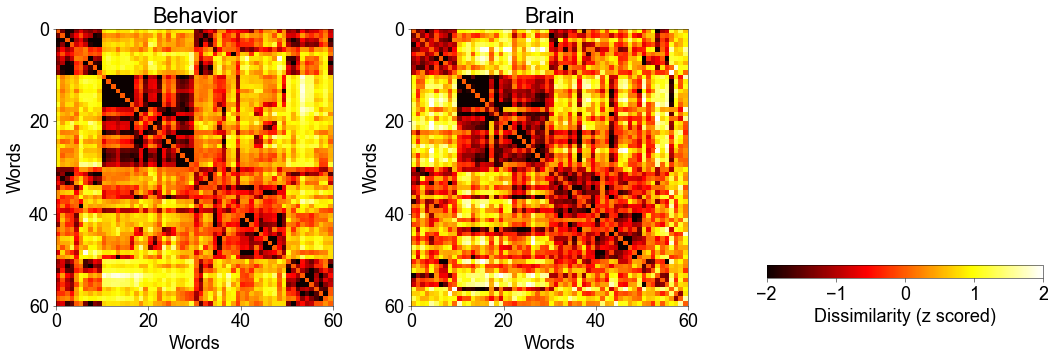

Adjective


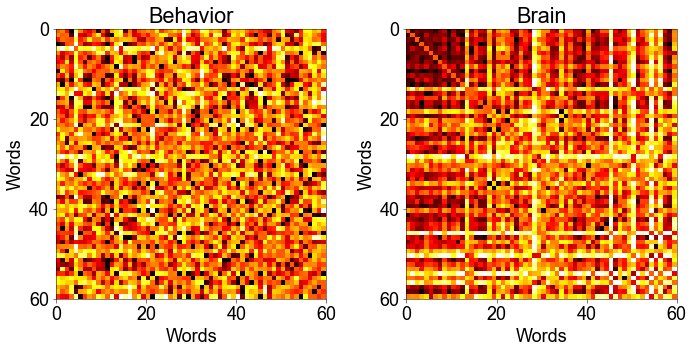

In [30]:
noun_dissim = np.zeros((2, behav_noun_dissim.shape[0]))
adj_dissim = np.zeros((2, behav_adj_dissim.shape[0]))

noun_dissim[0] = behav_noun_dissim_overlap
noun_dissim[1] = mov1_noun_dissim_overlap
adj_dissim[0] = behav_adj_dissim_overlap
adj_dissim[1] = mov1_adj_dissim_overlap

prefixes = ["behav", "brain"]
titles = ["Behavior", "Brain"]

min_val = -2
max_val = 2

# Noun

print("Noun")

fig = plt.figure(figsize=(15, 5))

for i, (p, t) in enumerate(zip(prefixes, titles)):
    ax = plt.subplot(1, 3, i + 1)
    ax.pcolor(distance.squareform(noun_dissim[i]), vmin=min_val, vmax=max_val, cmap="hot")
    ax.axis("square")

    ax.set_xlabel("Words")
    ax.set_xticks(np.linspace(0, 60, 4))
    ax.invert_yaxis()
    ax.set_ylabel("Words")
    ax.set_yticks(np.linspace(0, 60, 4))
    ax.set_title(t)

# Colorbar
ax = plt.subplot(1, 3, 3)

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

m = ax.pcolor(X, Y, Z, cmap="hot", vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(m, ax=ax, orientation="horizontal")
cbar.set_label("Dissimilarity (z scored)")

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, 'dissim_mat_mrisubj_noun.pdf'))
pp.savefig(fig, dpi=300, bbox_inches='tight')
pp.close()

##
# Adjective

print("Adjective")

fig = plt.figure(figsize=(10, 5))

for i, (p, t) in enumerate(zip(prefixes, titles)):
    ax = plt.subplot(1, 2, i + 1)
    ax.pcolor(distance.squareform(adj_dissim[i]), vmin=min_val, vmax=max_val, cmap="hot")
    ax.axis("square")

    ax.set_xlabel("Words")
    ax.set_xticks(np.linspace(0, 60, 4))
    ax.invert_yaxis()
    ax.set_ylabel("Words")
    ax.set_yticks(np.linspace(0, 60, 4))
    ax.set_title(t)

plt.tight_layout()
plt.show()

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, 'dissim_mat_mrisubj_adj.pdf'))
pp.savefig(fig, dpi=300, bbox_inches='tight')
pp.close()

### Correlation

In [31]:
print("Noun:")

coef, pval = stats.pearsonr(noun_dissim[0], noun_dissim[1])
print(" Behav & Brain: r = {}, p = {}".format(coef, pval))

print("Adjective:")

coef, pval = stats.pearsonr(adj_dissim[0], adj_dissim[1])
print(" Behav & Brain: r = {}, p = {}".format(coef, pval))

Noun:
 Behav & Brain: r = 0.5787999551102704, p = 7.656633732665483e-159
Adjective:
 Behav & Brain: r = 0.24360048323651615, p = 2.521457540824137e-25


## Figs. 5 and S6: Effects of voxel selection on dismilarity correlation

In [32]:
print("Number of cortical voxels")
for m in ["mov1", "mov2"]:
    n = eval(m + "_n_voxels")
    print(" {}: {}-{}, mean±SD = {} ± {}".format(m, int(n.min()), int(n.max()), n.mean(), n.std(ddof=1)))

n_n_sel_voxels = len(n_sel_voxels)

pos = ["noun", "adj"]
n_word_pairs = int(n_nouns * (n_nouns - 1) / 2)

behav_dissim = np.zeros((2, n_word_pairs))
brain_dissim = np.zeros((2, 2, n_n_sel_voxels + 1, n_word_pairs))

coefs = np.zeros((2, 2, n_n_sel_voxels + 1))  # POS x movie set x voxel selection
pvals = np.ones((2, 2, n_n_sel_voxels + 1))

for i in range(2):
    behav_dissim[i] = eval("behav_" + pos[i] + "_dissim")
        
    for j in range(2):
        for k in range(n_n_sel_voxels):

            brain_dissim[i, j, k] = eval("mov" + str(j + 1) + "_" + pos[i] + "_dissim_selvox")[dim_idx, k]
            coefs[i, j, k], pvals[i, j, k] = stats.pearsonr(brain_dissim[i, j, k], behav_dissim[i])

        brain_dissim[i, j, n_n_sel_voxels] = eval("mov" + str(j + 1) + "_" + pos[i] + "_dissim")[dim_idx]
        coefs[i, j, n_n_sel_voxels], pvals[i, j, n_n_sel_voxels] = stats.pearsonr(brain_dissim[i, j, n_n_sel_voxels], behav_dissim[i])

Number of cortical voxels
 mov1: 54914-73301, mean±SD = 62244.96428571428 ± 5018.100241696482
 mov2: 52832-73301, mean±SD = 62150.0 ± 5189.920378817149


### Bootstrapping

In [33]:
pairs = list(itertools.combinations(range(n_n_sel_voxels + 1), 2))
n_pairs = len(pairs)

n_itrs = 10000

boot_ci95 = np.zeros((2, 2, n_n_sel_voxels + 1, 2))  # POS x movie set x lower/upper
boot_pvals = np.ones((2, 2, n_pairs))  # POS x movie set x voxel selection  pair

for i in range(2):
    print(pos[i])
    xsamps = behav_dissim[i]
    
    for j in range(2):
        print("mov" + str(j + 1))
        ysamps = brain_dissim[i, j]
        
        r_samps = np.zeros((n_itrs, n_n_sel_voxels + 1))
        diff_samps = np.zeros((n_itrs, n_pairs))
        
        # Bootstrapping
        for bi in range(n_itrs):
            
            # Resample indices
            ids = np.random.choice(n_word_pairs, n_word_pairs, replace=True)
            
            r_samps[bi] = [stats.pearsonr(xsamps[ids], y[ids])[0] for y in ysamps]
            diff_samps[bi] = [r_samps[bi][p[0]] - r_samps[bi][p[1]] for p in pairs]
            
        # 95% confidence interval
        sort_r_samps = np.sort(r_samps, axis=0)
        boot_ci95[i, j, :, 0] = coefs[i, j, :] - sort_r_samps[int(n_itrs * 0.025), :]  # Lower interval
        boot_ci95[i, j, :, 1] = sort_r_samps[int(n_itrs * 0.975), :] - coefs[i, j, :]  # Upper interval
        
        # P value
        ps = np.sum(diff_samps < 0, axis=0) / n_itrs
        ps[ps > 0.5] = 1 - ps[ps > 0.5]
        boot_pvals[i, j] = ps

noun
mov1
mov2
adj
mov1
mov2


### Function of correaltion coefficients against the number of selected voxels

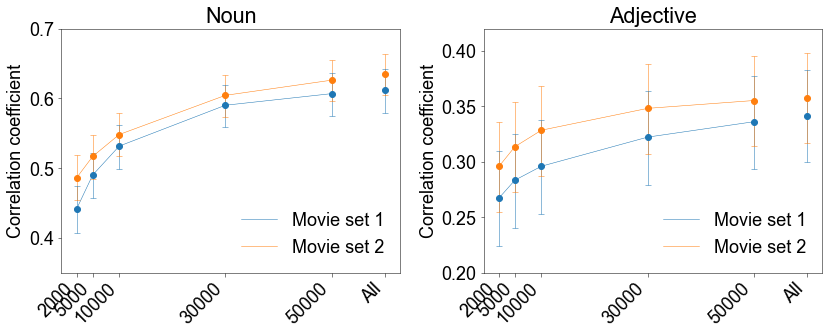

In [34]:
# Nouns

xlabels = np.append(n_sel_voxels, "All")
n_xlabels = len(xlabels)

grp_labels = ["Movie set 1", "Movie set 2"]

fig = plt.figure(figsize=(12, 5))

ax = plt.subplot(1, 2, 1)

x = np.hstack([n_sel_voxels, n_sel_voxels[-1] * 1.2])
y = coefs[0]
e = boot_ci95[0]
for i in range(2):
    ax.plot(x[:-1], y[i][:-1], c=mpl.cm.tab10(i))
    ax.errorbar(x, y[i], marker="o", yerr=e[i].T, c=mpl.cm.tab10(i), lw=0, elinewidth=.5, capthick=.5, capsize=3)

ax.legend(grp_labels, loc="lower right", frameon=False)

ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=45, ha="right")
ax.set_ylim([0.35, 0.7])
ax.set_ylabel("Correlation coefficient")
ax.set_title("Noun")

##
# Adjectives

ax = plt.subplot(1, 2, 2)

x = np.hstack([n_sel_voxels, n_sel_voxels[-1] * 1.2])
y = coefs[1]
e = boot_ci95[1]
for i in range(2):
    ax.plot(x[:-1], y[i][:-1], c=mpl.cm.tab10(i))
    ax.errorbar(x, y[i], marker="o", yerr=e[i].T, c=mpl.cm.tab10(i), lw=0, elinewidth=.5, capthick=.5, capsize=3)

ax.legend(grp_labels, loc="lower right", frameon=False)

ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=45, ha="right")
ax.set_ylim([0.2, 0.42])
ax.set_ylabel("Correlation coefficient")
ax.set_title("Adjective")

plt.tight_layout()
plt.show()

##

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, 'dissim_corr_selvox.pdf'))
pp.savefig(fig, dpi=300, bbox_inches='tight')
pp.close()

### Comparison across voxel selections

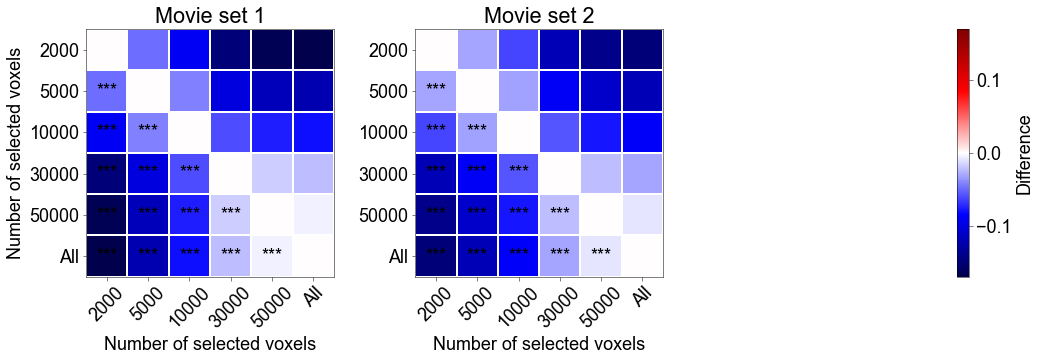

In [35]:
# Noun

pairs = list(itertools.combinations(range(n_xlabels), 2))

n_noun_pairs = n_nouns * (n_nouns - 1) / 2

diff_vals = []
corr_pvals = []
for i in range(2):
    diff_vals.append([coefs[0, i, x[0]] - coefs[0, i, x[1]] for x in pairs])
    
    # FDR correction
    corr_pvals.append(fdrcorrection(boot_pvals[0, i], alpha=thresh_alpha)[1])

max_val = np.max([np.abs(np.max(diff_vals)), np.abs(np.min(diff_vals))])
min_val = -max_val

##
# Plot
cm = "seismic"
mk_col = "k"

fig = plt.figure(figsize=(15, 5))

for i, (vals, ps) in enumerate(zip(diff_vals, corr_pvals)):
    
    ax = plt.subplot(1, 3, i + 1)
    ax.pcolor(distance.squareform(vals), vmin=min_val, vmax=max_val, cmap=cm, ec="w", lw=1)
    ax.axis("square")
    
    for j, p in enumerate(pairs):
        mk = ""
        if ps[j] < 0.0001:
            mk = "***"
        elif ps[j] < 0.01:
            mk = "**"
        elif ps[j] < 0.05:
            mk = "*"
        elif ps[j] > 0.05:
            mk = "n.s."
        
        if mk is not "":
            ax.text(p[0] + .5, p[1] + .5, mk, c=mk_col, ha="center", va="center")
    
    ax.set_xticks(np.arange(n_xlabels) + .5)
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_xlabel("Number of selected voxels")
    
    ax.invert_yaxis()
    ax.set_yticks(np.arange(n_xlabels) + .5)
    ax.set_yticklabels(xlabels)
    if i == 0:
        ax.set_ylabel("Number of selected voxels")
        
    if i == 0:
        ax.set_title("Movie set 1")
    elif i == 1:
        ax.set_title("Movie set 2")

# Colorbar

ax = plt.subplot(1, 3, 3)

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

mappable = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(mappable, ax=ax, orientation="vertical")
cbar.set_label("Difference")

plt.tight_layout()
plt.show()

##

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, 'dissim_corr_cmpr_selvox_noun.pdf'))
pp.savefig(fig, dpi=300, bbox_inches='tight')
pp.close()

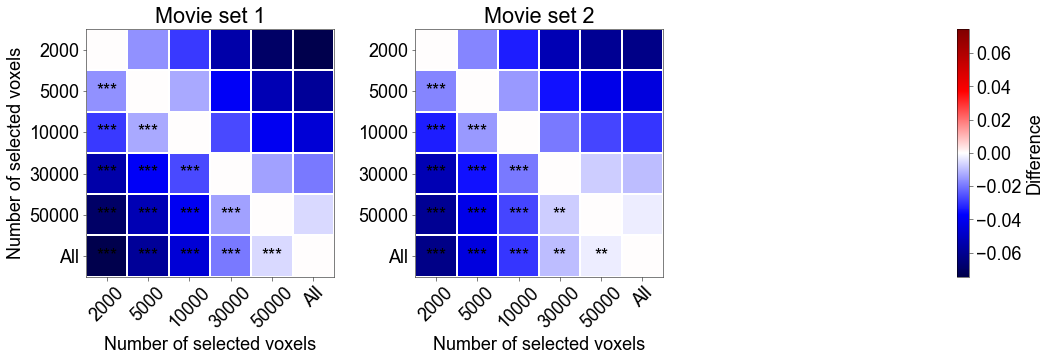

In [36]:
# Adjective

pairs = list(itertools.combinations(range(n_xlabels), 2))

n_adj_pairs = n_adjs * (n_adjs - 1) / 2

diff_vals = []
corr_pvals = []
for i in range(2):
    diff_vals.append([coefs[1, i, x[0]] - coefs[1, i, x[1]] for x in pairs])
    
    # FDR correction
    corr_pvals.append(fdrcorrection(boot_pvals[1, i], alpha=thresh_alpha)[1])

max_val = np.max([np.abs(np.max(diff_vals)), np.abs(np.min(diff_vals))])
min_val = -max_val

##
# Plot
cm = "seismic"
mk_col = "k"

fig = plt.figure(figsize=(15, 5))

for i, (vals, ps) in enumerate(zip(diff_vals, corr_pvals)):
    
    ax = plt.subplot(1, 3, i + 1)
    ax.pcolor(distance.squareform(vals), vmin=min_val, vmax=max_val, cmap=cm, ec="w", lw=1)
    ax.axis("square")
    
    for j, p in enumerate(pairs):
        mk = ""
        if ps[j] < 0.0001:
            mk = "***"
        elif ps[j] < 0.01:
            mk = "**"
        elif ps[j] < 0.05:
            mk = "*"
        elif ps[j] > 0.05:
            mk = "n.s."
        
        if mk is not "":
            ax.text(p[0] + .5, p[1] + .5, mk, c=mk_col, ha="center", va="center")
    
        ax.set_xticks(np.arange(n_xlabels) + .5)
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_xlabel("Number of selected voxels")
    
    ax.invert_yaxis()
    ax.set_yticks(np.arange(n_xlabels) + .5)
    ax.set_yticklabels(xlabels)
    if i == 0:
        ax.set_ylabel("Number of selected voxels")
        
    if i == 0:
        ax.set_title("Movie set 1")
    elif i == 1:
        ax.set_title("Movie set 2")

# Colorbar

ax = plt.subplot(1, 3, 3)

x = np.arange(0, 1)
y = np.arange(0, 1)
X, Y = np.meshgrid(x, y)
Z = np.arange(len(x) * len(y)).reshape(len(y), -1)

mappable = ax.pcolor(X, Y, Z, cmap=cm, vmin=min_val, vmax=max_val)
ax.set_axis_off()

cbar = fig.colorbar(mappable, ax=ax, orientation="vertical")
cbar.set_label("Difference")
cbar.set_ticks([-.06, -.04, -.02, 0, .02, .04, .06])

plt.tight_layout()
plt.show()

##

# Save the figure as a PDF file
pp = PdfPages(os.path.join(out_dir, 'dissim_corr_cmpr_selvox_adj.pdf'))
pp.savefig(fig, dpi=300, bbox_inches='tight')
pp.close()